In [1]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import rgb2hex
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import squarify
from plotly.offline import init_notebook_mode,iplot
from wordcloud import WordCloud
import numpy as np 
from scipy import stats
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors 
from collections import Counter
cmap2 = cm.get_cmap('twilight',13)
colors1= []
for i in range(cmap2.N):
    rgb= cmap2(i)[:4]
    colors1.append(rgb2hex(rgb))

# Set style
sns.set(style='whitegrid')

### Load the data

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/thunderstroke325/60-Days-of-Data-Science-and-ML/main/datasets/marketing_campaign.csv', low_memory = False, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [32]:
# Fill missing data in the income column with mean
df['Income'].fillna((df['Income'].mean()),inplace=True)

# Again Check for missing values
df.isna().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

### Feature Engineering

In [33]:
# Grouping Education 
df['Education']=df['Education'].str.replace('Graduation','Higher Education')
df['Education']=df['Education'].str.replace('PhD','Higher Education')
df['Education']=df['Education'].str.replace('Master','Higher Education')
df['Education']=df['Education'].str.replace('2n Cycle','Higher Education')

# Goruping Marital Status
df['Marital_Status']=df['Marital_Status'].str.replace('Married','In A Relationship')
df['Marital_Status']=df['Marital_Status'].str.replace('Together','In A Relationship')
df['Marital_Status']=df['Marital_Status'].str.replace('Divorced','Single')
df['Marital_Status']=df['Marital_Status'].str.replace('Widow','Single')
df['Marital_Status']=df['Marital_Status'].str.replace('Alone','Single')
df['Marital_Status']=df['Marital_Status'].str.replace('Absurd','Single')
df['Marital_Status']=df['Marital_Status'].str.replace('YOLO','Single')

# Grouping Kids
df['Total_child']=df['Kidhome'] +df['Teenhome']

# Campaign
df['Camp_total']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3'] +df['AcceptedCmp4']+df['AcceptedCmp5'] +df['Response']
df.info()

# Total purchase
df['Total_purchase'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

# Age
df['Age'] = 2021 - df.Year_Birth

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [34]:
# Removing Outliers
df=df.loc[np.abs(stats.zscore(df['Income']))<3]
df.reset_index(inplace=True)
df=df.drop(columns=['index'])  
df.shape

(2232, 33)

In [35]:
# Remove unnecessary columns and choose necessary ones
cols=['Education', 'Marital_Status', 'Income','Recency'
             , 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 
             'NumStorePurchases', 'NumWebVisitsMonth', 'Complain','Camp_total', 'Total_child', "Total_purchase"]
c_df=df[cols]
# Label Encoding the Data  ( Education and Marital Status Column)
l=LabelEncoder()
c_df['Education']=c_df[['Education']].apply(l.fit_transform)
c_df['Marital_Status']=c_df[['Marital_Status']].apply(l.fit_transform)
# Standard Scaling
ss=StandardScaler()
c_df_final=ss.fit_transform(c_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



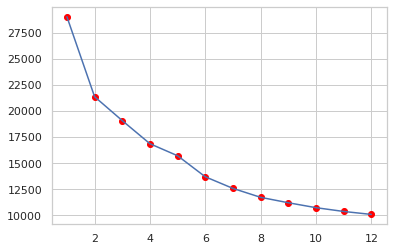

In [36]:
# Optimum no of Clusters
l1=[]
for i in range(1,13):
    k_mean=KMeans(n_clusters=i,random_state=42,init="k-means++")
    k_mean.fit(c_df_final)
    l1.append(k_mean.inertia_)
plt.plot(range(1,13),l1)
plt.scatter(range(1,13),l1,color="red")

plt.show()

### K-means clustering method

1.   Divide into number of cluster K
2.   Find the centroid of the current partition
3.   Calculate the distance each points to Centroids
4.   Group based on minimum distance
5.   After re-grouping/re-allotting points, find the new centroid of the new cluster



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



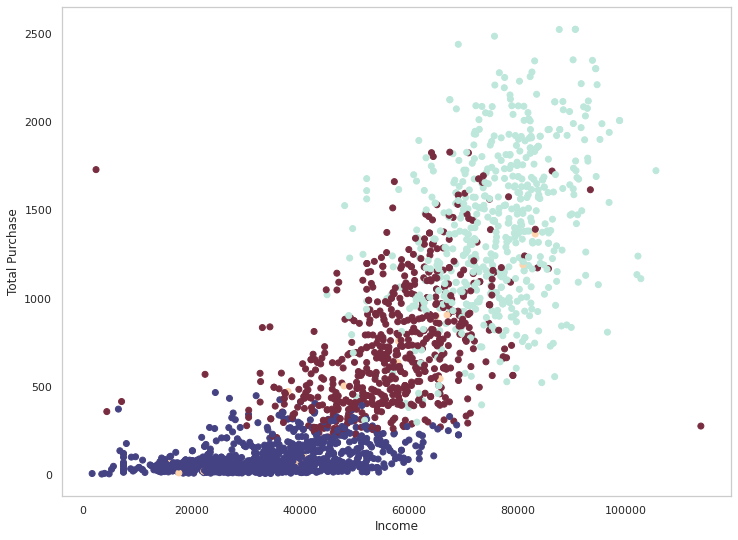

In [39]:
# Kmeans ( 4 Clusters )
km=KMeans(n_clusters=4,random_state=0,init="k-means++")
km.fit(c_df_final)
clusters=km.predict(c_df_final)
c_df['cluster_no'] = clusters
#plot
plt.figure(figsize=(12,9))
plt.scatter(df['Income'],df['Total_purchase'],c=clusters, cmap='icefire')
plt.xlabel('Income')
plt.ylabel('Total Purchase')
plt.grid(False)

plt.show()

In [40]:
c_df['cluster_no'].value_counts()

1    1003
2     627
0     581
3      21
Name: cluster_no, dtype: int64

In [41]:
print("Cluster 0 Total Spending: ", c_df.loc[c_df['cluster_no']== 0 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 1 Total Spending: ",c_df.loc[c_df['cluster_no']== 1 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 2 Total Spending: ",c_df.loc[c_df['cluster_no']== 2 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 3 Total Spending: ",c_df.loc[c_df['cluster_no']== 3 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 0 Income: ",c_df.loc[c_df['cluster_no']== 0 ,['Income'] ].mean()['Income'])
print("Cluster 1 Income: ",c_df.loc[c_df['cluster_no']== 1 ,['Income'] ].mean()['Income'])
print("Cluster 2 Income: ",c_df.loc[c_df['cluster_no']== 2 ,['Income'] ].mean()['Income'])
print("Cluster 3 Income: ",c_df.loc[c_df['cluster_no']== 3 ,['Income'] ].mean()['Income'])

Cluster 0 Total Spending:  1375.0567986230637
Cluster 1 Total Spending:  93.29910269192423
Cluster 2 Total Spending:  719.7751196172248
Cluster 3 Total Spending:  376.42857142857144
Cluster 0 Income:  75756.4251384082
Cluster 1 Income:  34397.39807337914
Cluster 2 Income:  57090.66309326401
Cluster 3 Income:  45242.28571428572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



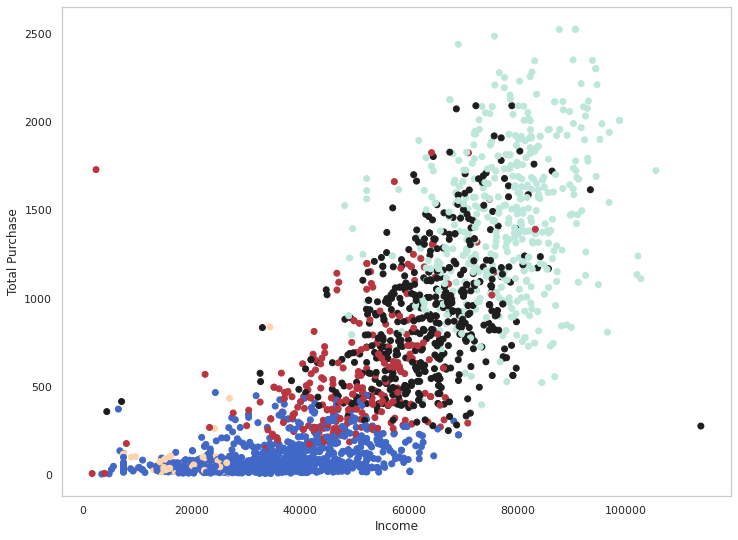

In [42]:
# Kmeans 5 clusters
km=KMeans(n_clusters=5,random_state=0,init="k-means++")
km.fit(c_df_final)
clusters=km.predict(c_df_final)
c_df['cluster_no'] = clusters
#plot
plt.figure(figsize=(12,9))
plt.scatter(df['Income'],df['Total_purchase'],c=clusters, cmap='icefire')
plt.xlabel('Income')
plt.ylabel('Total Purchase')
plt.grid(False)

plt.show()

In [43]:
c_df['cluster_no'].value_counts()

1    960
2    485
0    475
3    258
4     54
Name: cluster_no, dtype: int64

In [44]:
print("Cluster 0 Total Spending: ", c_df.loc[c_df['cluster_no']== 0 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 1 Total Spending: ",c_df.loc[c_df['cluster_no']== 1 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 2 Total Spending: ",c_df.loc[c_df['cluster_no']== 2 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 3 Total Spending: ",c_df.loc[c_df['cluster_no']== 3 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 4 Total Spending: ",c_df.loc[c_df['cluster_no']== 4 ,['Total_purchase'] ].mean()['Total_purchase'])
print("Cluster 0 Income: ",c_df.loc[c_df['cluster_no']== 0 ,['Income'] ].mean()['Income'])
print("Cluster 1 Income: ",c_df.loc[c_df['cluster_no']== 1 ,['Income'] ].mean()['Income'])
print("Cluster 2 Income: ",c_df.loc[c_df['cluster_no']== 2 ,['Income'] ].mean()['Income'])
print("Cluster 3 Income: ",c_df.loc[c_df['cluster_no']== 3 ,['Income'] ].mean()['Income'])
print("Cluster 4 Income: ",c_df.loc[c_df['cluster_no']== 4 ,['Income'] ].mean()['Income'])

Cluster 0 Total Spending:  1434.7705263157895
Cluster 1 Total Spending:  97.28125
Cluster 2 Total Spending:  886.5505154639176
Cluster 3 Total Spending:  551.9031007751938
Cluster 4 Total Spending:  81.79629629629629
Cluster 0 Income:  77374.4126429793
Cluster 1 Income:  35320.49533224278
Cluster 2 Income:  63152.308771260556
Cluster 3 Income:  49903.40214752469
Cluster 4 Income:  20306.25925925926
